In [1]:
import shap
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import seaborn as sns
from numpy import sqrt, argsort
from tqdm import tqdm, trange

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

import xgboost

In [2]:
# load the data
data = pd.read_csv('DataSetForThesis2.csv')

del data["Discharge Flow (Nominal m3/hr)"]

# drop the second row
data = data.iloc[1:,:]

# check the missing values
print(f"Missing Values?: {data.isna().sum().any()}")

# drop the missing values
data.dropna(inplace=True)

print(f"Missing Values After Dropping?: {data.isna().sum().any()}")

# check the duplicates
print(f"Number Of Duplicates: {data.duplicated().sum()}")

print(" ")

# change the data type of the columns to float and date time 
cols=[i for i in data.columns if i not in ['Date/Time']]
for col in cols:
    data[col]=pd.to_numeric(data[col])
    
data['Date/Time'] = pd.to_datetime(data['Date/Time'])

time_period=data['Date/Time']

data.head()

Missing Values?: True
Missing Values After Dropping?: False
Number Of Duplicates: 0
 


,Date/Time,Suction Pressure (Bar Gauge without Atmospheric pressure),Suction Flow (Nominal m3/hr),Suction Temperature (oC),Dischrage PreG1e without Atmospheric pressure),Discharge Temperature (oC),Gear Box Output Shaft Drive End (DE) X Vibration (μm),Gear Box Output Shaft Drive End (DE) Y Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Input Shaft Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Drive End (DE) X Vibration (μm),Gear Box Input Shaft Drive End (DE) Y Vibration (μm),Suction Vibration in x,Suction Vibration in y,Discharge Vibration in x,Discharge Vibration in y,Compressor speed (RPM)
1,2020-11-07 00:00:00,5.2,26812.4,28.5,7.4,55.2,3.0,4.0,5.0,6.8,6.6,6.60,6.9,7.4,9.727419,10.204235,7.166746,9.235712,8164.449219
2,2020-11-07 00:20:00,5.2,26836.2,28.4,7.4,55.2,3.0,4.0,5.1,7.0,6.7,6.54,6.8,7.5,9.721112,10.209536,7.135931,9.235712,8161.888184
3,2020-11-07 00:40:00,5.2,26856.7,28.3,7.4,55.2,3.1,4.0,5.3,7.3,6.7,6.46,5.7,7.4,9.714805,10.214835,7.105114,9.178102,8162.304688
4,2020-11-07 01:00:00,5.2,26800.2,28.2,7.4,55.2,3.1,4.0,5.1,7.1,6.8,6.49,7.6,7.4,9.708497,10.220136,7.074298,9.116689,8315.385742
5,2020-11-07 01:20:00,5.2,26852.4,28.1,7.4,55.3,3.1,4.2,5.0,6.7,6.7,6.61,7.6,7.5,9.702189,10.225435,7.043482,9.139559,8217.386719


In [3]:
# ADNOC DataSet
data=data.iloc[:,1:]


target='Suction Temperature (oC)'
training_size=0.67

X = data.drop(columns=target)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-training_size)
# Prepares a default instance of the random forest regressor
model = RandomForestRegressor()
# Fits the model on the data
model.fit(X_train, y_train)

RandomForestRegressor()

In [4]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 8674it [1:21:27,  1.77it/s]                          


Bar Plot


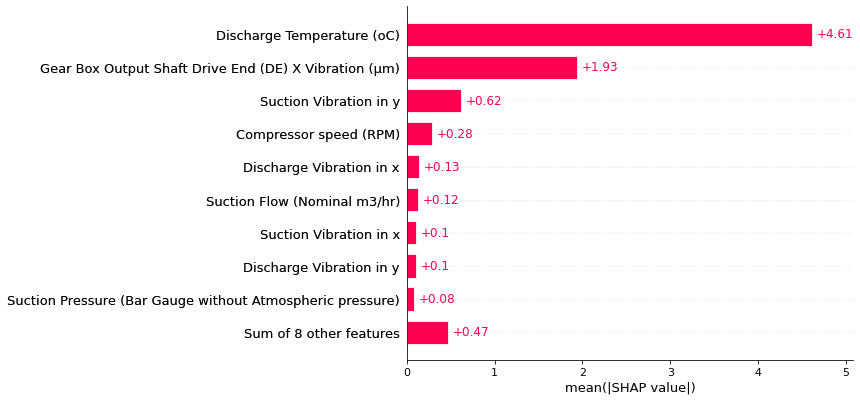

In [33]:
print("Bar Plot")
shap.plots.bar(shap_values, show=False)
#plt.savefig('SHAPELY Bar Plot from Suction Temperature as the target feature.png')

Here the features are ordered from the highest to the lowest effect on the prediction. It takes in account the absolute SHAP value, so it does not matter if the feature affects the prediction in a positive or negative way.

Bee Swarm Plot


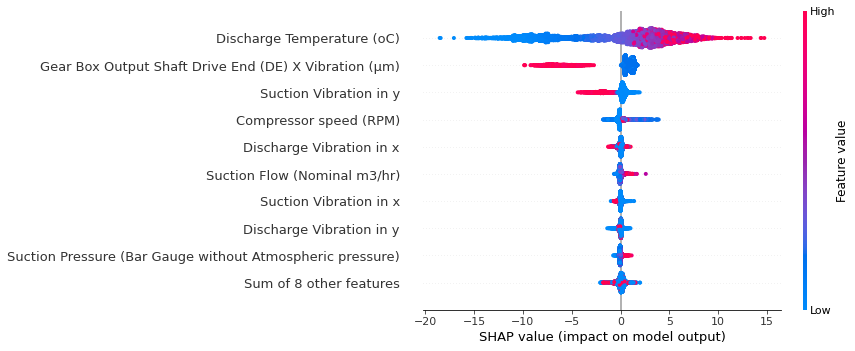

In [31]:
print("Bee Swarm Plot")
shap.plots.beeswarm(shap_values, show=False)
plt.savefig('SHAPELY Bee Swarm Plot from Suction Temperature as the target feature.png')

On the beeswarm the features are also ordered by their effect on prediction, but we can also see how higher and lower values of the feature will affect the result.

All the little dots on the plot represent a single observation. The horizontal axis represents the SHAP value, while the color of the point shows us if that observation has a higher or a lower value, when compared to other observations.

In this example, higher latitudes and longitudes have a negative impact on the prediction, while lower values have a positive impact.

Violin Plot


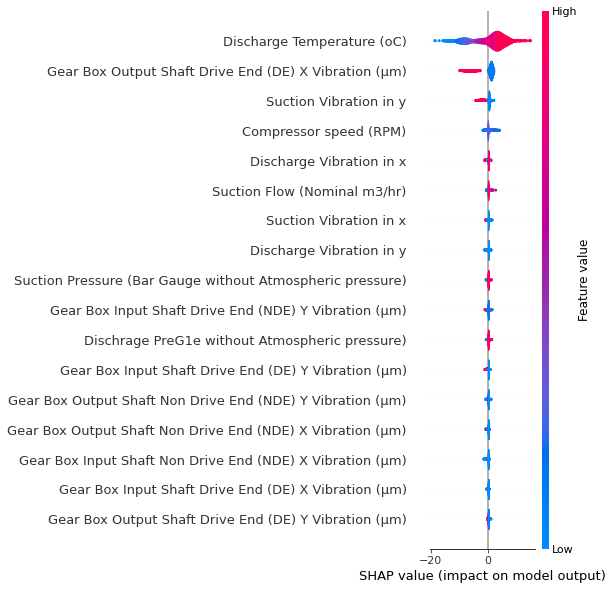

<Figure size 432x288 with 0 Axes>

In [14]:
print("Violin Plot")
shap.summary_plot(shap_values, plot_type='violin')
plt.savefig('SHAPELY Violin Plot from Suction Temperature as the target feature.png')

Another way to see the information of the beeswarm is by using the violin plot

Local Bar Plot


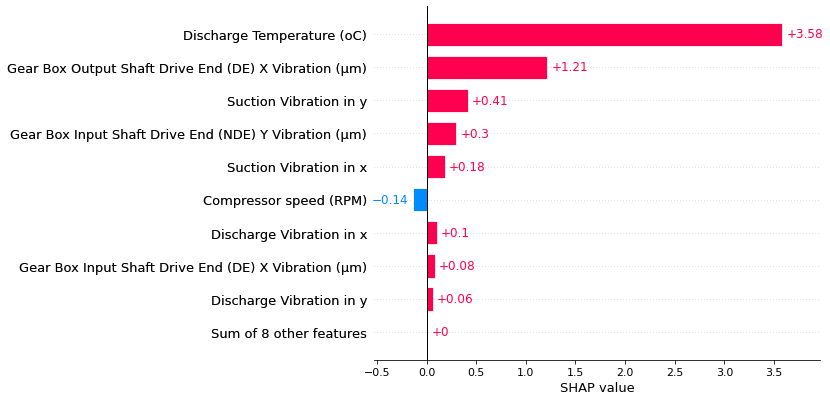

<Figure size 432x288 with 0 Axes>

In [15]:
print("Local Bar Plot")
shap.plots.bar(shap_values[0])
plt.savefig('SHAPELY Local Bar Plot from Suction Temperature as the target feature.png')

This plot shows us what are the main features affecting the prediction of a single observation, and the magnitude of the SHAP value for each feature.

Waterfall Plot


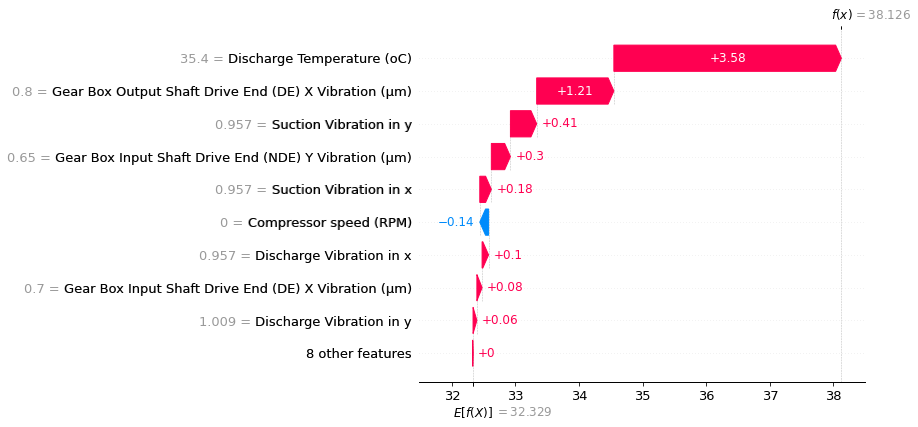

<Figure size 432x288 with 0 Axes>

In [27]:
print("Waterfall Plot")
shap.plots.waterfall(shap_values[0])
plt.savefig('SHAPELY Waterfall Plot from Suction Temperature as the target feature.png')

The waterfall plot has the same information, represented in a different manner. Here we can see how the sum of all the SHAP values equals the difference between the prediction $f(x)$ and the expected value $E[f(x)]$.